In [1]:
# Import packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

In [2]:
train = pd.read_excel('lendingclub_traindata.xlsx')
test = pd.read_excel('lendingclub_testdata.xlsx')

# 1 = good, 0 = default

# give column names
cols = ['home_ownership', 'income', 'dt1','fico_low','loan_status']
train.columns = test.columns = cols

print(train.head())
print("---------------------")
print(test.head())

   home_ownership  income    dt1  fico_low  loan_status
0               1  44.304  18.47       690            0
1               0  38.500  33.73       660            0
2               1  54.000  19.00       660            0
3               1  60.000  33.98       695            0
4               0  39.354  10.85       685            0
---------------------
   home_ownership  income    dt1  fico_low  loan_status
0               1   127.0  10.94       675            0
1               1   197.0  15.64       710            0
2               1    25.5  28.75       670            0
3               1    80.0  20.16       660            0
4               0    57.0  30.60       675            0


In [3]:
# remove target column to create feature only dataset
X_train = train.drop('loan_status', 1)
X_test = test.drop('loan_status',1)

# store target column
y_train = train['loan_status']
y_test = test['loan_status']

print(X_train, y_train.shape, X_test.shape, y_test.shape)
X_train.columns

      home_ownership   income    dt1  fico_low
0                  1   44.304  18.47       690
1                  0   38.500  33.73       660
2                  1   54.000  19.00       660
3                  1   60.000  33.98       695
4                  0   39.354  10.85       685
...              ...      ...    ...       ...
8690               0   53.000  36.16       685
8691               1  113.500  11.18       690
8692               0  118.000   1.85       785
8693               1   82.000  10.90       705
8694               0  150.000  19.02       745

[8695 rows x 4 columns] (8695,) (5916, 4) (5916,)


Index(['home_ownership', 'income', 'dt1', 'fico_low'], dtype='object')

In [4]:
majority_class = y_train.mode()[0]
prediction = np.full(shape=y_train.shape, fill_value=majority_class)
accuracy_score(y_train, prediction)

0.8276020701552617

In [5]:
freq = y_train.value_counts() # count frequency of different classes in loan status
freq/sum(freq)*100

1    82.760207
0    17.239793
Name: loan_status, dtype: float64

In [6]:
lgstc_reg = LogisticRegression(penalty="none",solver='newton-cg') 

lgstc_reg.fit(X_train, y_train)

print(lgstc_reg.intercept_, lgstc_reg.coef_)

[-6.5652302] [[ 0.139496    0.00410667 -0.00112302  0.0112521 ]]


In [7]:
y_pred = lgstc_reg.predict(X_test) # predict default loans based on test data set

In [8]:
THRESHOLD = [.75,.80,.85]
results = pd.DataFrame(columns = ['THRESHOLD','accuracy','retail','thr',
                                  'fpr','precision','f1_score'])
results['THRESHOLD'] = THRESHOLD # threshold column

j = 0
for i in THRESHOLD:
    lgstc_reg.fit(X_train, y_train)
    preds = np.where(lgstc_reg.predict_proba(X_test)[:,1] > i,1,0)
    
    cm = (confusion_matrix(y_test, preds, labels=[1,0], sample_weight=None)/5916)*100
    
    print('Confusion matrix for threshold =',i)
    print(cm)
    print(' ')
    
    TP = cm[0][0]
    FN = cm[0][1]
    FP = cm[1][0]
    TN = cm[1][1]
    
    results.iloc[j,1] = accuracy_score(y_test, preds)
    results.iloc[j,2] = recall_score(y_test, preds)
    results.iloc[j,3] = TN/(FP+TN)
    results.iloc[j,4] = FP/(FP+TN)
    results.iloc[j,5] = precision_score(y_test, preds)
    results.iloc[j,6] = f1_score(y_test, preds)
    
    j+=1
    
print('ALL METRICS')
print( results.T) # transpose

Confusion matrix for threshold = 0.75
[[77.5862069   4.5300879 ]
 [16.26098715  1.62271805]]
 
Confusion matrix for threshold = 0.8
[[55.34144692 26.77484787]
 [ 9.75321163  8.13049358]]
 
Confusion matrix for threshold = 0.85
[[28.65111562 53.46517918]
 [ 3.73563218 14.14807302]]
 
ALL METRICS
                  0         1         2
THRESHOLD      0.75       0.8      0.85
accuracy   0.792089  0.634719  0.427992
retail     0.944833   0.67394  0.348909
thr        0.090737  0.454631  0.791115
fpr        0.909263  0.545369  0.208885
precision  0.826729  0.850169  0.884656
f1_score   0.881844  0.751866  0.500443


In [9]:
print('ALL METRICS')
print(results.T)

ALL METRICS
                  0         1         2
THRESHOLD      0.75       0.8      0.85
accuracy   0.792089  0.634719  0.427992
retail     0.944833   0.67394  0.348909
thr        0.090737  0.454631  0.791115
fpr        0.909263  0.545369  0.208885
precision  0.826729  0.850169  0.884656
f1_score   0.881844  0.751866  0.500443


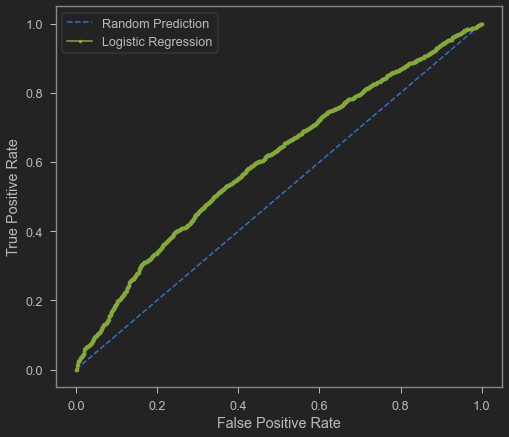

0.5
0.6019670358405561


In [10]:
lr_prob = lgstc_reg.predict_proba(X_test) # logistic regressing prob
lr_prob=lr_prob[:,1]
ns_prob = [0 for _ in range(len(y_test))] 

ns_fpr, ns_tpr,_ = roc_curve(y_test, ns_prob)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_prob)

plt.plot(ns_fpr, ns_fpr, linestyle='--', label="Random Prediction")
plt.plot(lr_fpr, lr_tpr, marker='.', label = 'Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

ns_auc=roc_auc_score(y_test, ns_prob)
lr_auc=roc_auc_score(y_test, lr_prob)

print(ns_auc)
print(lr_auc)

### 최적의 z 선택

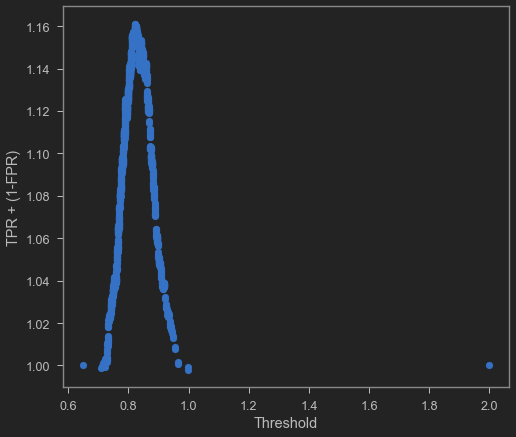

Z = 0.822062594595606


In [12]:
# ROC curve 기준
lr_fpr, lr_tpr, threshold = roc_curve(y_test, lr_prob)

plt.scatter(threshold, np.abs(lr_tpr+1-lr_fpr))
plt.xlabel('Threshold')
plt.ylabel('TPR + (1-FPR)')
plt.show()

Z_opt_roc = threshold[np.argmax(lr_tpr+1-lr_fpr)]
print("Z =", Z_opt_roc)

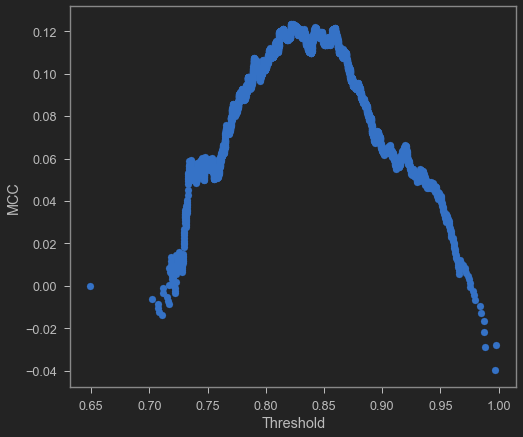

Z = 0.822062594595606


In [13]:
# MCC 기준
from sklearn.metrics import matthews_corrcoef

threshold = []
mcc = []

for phat in np.unique(lr_prob):
    threshold_tmp = phat # 각 phat을 threshold로 설정
    threshold.append(phat)
    yhat_test = (lr_prob >= threshold_tmp).astype(int)
    mcc.append(matthews_corrcoef(y_test, yhat_test))
    
plt.scatter(threshold, mcc)
plt.xlabel("Threshold")
plt.ylabel("MCC")
plt.show()

Z_opt_mcc = threshold[np.argmax(mcc)]
print("Z =", Z_opt_mcc)